<a href="https://colab.research.google.com/github/rubythalib33/machine-learning-hub/blob/main/Reinforcement%20Learning/PPO_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 32.8 MB/s 


In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# This code is from openai baseline
# https://github.com/openai/baselines/tree/master/baselines/common/vec_env

import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

        
class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

In [9]:
num_envs = 16
env_name = "Pendulum-v1"

def make_env():
  def _thunk():
    env = gym.make(env_name)
    return env
  
  return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step 

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [11]:
class ActorCritic(nn.Module):
  def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
    super(ActorCritic, self).__init__()
    
    self.critic = nn.Sequential(
        nn.Linear(num_inputs, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )

    self.actor = nn.Sequential(
        nn.Linear(num_inputs, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_outputs)
    )
    self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)

    self.apply(init_weights)

  def forward(self, x):
    value = self.critic(x)
    mu = self.actor(x)
    std = self.log_std.exp().expand_as(mu)
    dist = Normal(mu, std)

    return dist, value

In [12]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def test_env(model, vis=True):
  state = env.reset()
  if vis: env.render()
  done = False
  total_reward = 0
  while not done:
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    dist, _ = model(state)
    next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
    state = next_state
    if vis: env.render()
    total_reward += reward
  return total_reward

# GAE

In [13]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

#Proximal Policy Optimization Algorithm

In [14]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [15]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
max_frames = 15000
frame_idx  = 0
test_rewards = []

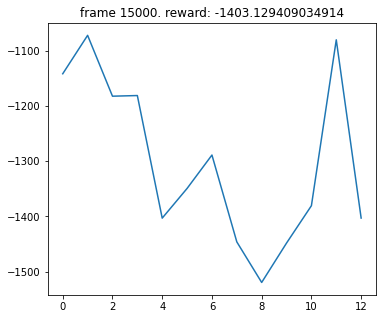

In [20]:
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(model, False) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

In [21]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -1504.7394493927188
episode: 1 reward: -1447.2409502277048
episode: 2 reward: -1521.336910792674
episode: 3 reward: -1440.4739874474678
episode: 4 reward: -1407.145554649016
episode: 5 reward: -1400.4571585736157
episode: 6 reward: -1386.912723402679
episode: 7 reward: -1388.9635123793769
episode: 8 reward: -1429.7896707690586
episode: 9 reward: -1408.8175928736312
episode: 10 reward: -1376.7306057099113
episode: 11 reward: -1512.1735971764933
episode: 12 reward: -1389.1483852600772
episode: 13 reward: -1433.1236223864498
episode: 14 reward: -1392.6073619031167
episode: 15 reward: -1529.9447054529765
episode: 16 reward: -1409.403788298406
episode: 17 reward: -1346.4298112838912
episode: 18 reward: -1405.7618718073197
episode: 19 reward: -1396.6400185242535
episode: 20 reward: -1418.8658165338798
episode: 21 reward: -1478.1725197017486
episode: 22 reward: -1418.3280206474774
episode: 23 reward: -1441.921160037064
episode: 24 reward: -1429.1629106025691
episode: 25 rew